#### Simple MLP Baseline for Image classification for the CIFAR-10 dataset

In [1]:
import torch
import torchvision.datasets as datasets
from torchvision.transforms import v2
import torch.utils.data as dataloader
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
# Params for wandb sweeps
PROJECT_NAME = 'mlp_cifar10_pytorch'
PROJECT_ENTITY = 'cs20b013-bersilin'

# The 10 classes in the CIFAR-10 dataset
LABELS = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# The architecture of the MLP model
ARCH = [500, 250, 100]
DATA_DIR = "../data"

In [3]:
def get_transform(mean, std):
    '''
    Returns a transform to convert a CIFAR image to a tensor of type float32
    '''
    return v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean, std)
    ])

In [4]:
def get_dataloader(batch_size: int, val_split: float = 0.2, shuffle: bool = True):
    '''
    Load the CIFAR-10 dataset

    Normalizes the data using the mean and standard deviation of the training data
    '''
    train_data = datasets.CIFAR10(root=DATA_DIR, train=True, download=True)
    test_data = datasets.CIFAR10(root=DATA_DIR, train=False, download=True)

    mean = np.array(train_data.data).mean(axis=(0, 1, 2)) / 255
    std = np.array(train_data.data).std(axis=(0, 1, 2)) / 255

    transform = get_transform(mean, std)
    train_data.transform = transform
    test_data.transform = transform

    train_size = int((1 - val_split) * len(train_data))
    val_size = len(train_data) - train_size

    train_data, val_data = dataloader.random_split(train_data, [train_size, val_size])

    train_loader = dataloader.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    val_loader = dataloader.DataLoader(val_data, batch_size=batch_size, shuffle=shuffle)
    test_loader = dataloader.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_data, test_data, train_loader, val_loader, test_loader, mean, std

In [5]:
def show_random_image(dataset: datasets.CIFAR10, index: int = None, mean: np.ndarray = None, std: np.ndarray = None):
    '''
    Shows a random image from the dataset

    If the mean and standard deviation are provided, the image is denormalized
    If the index is provided, the image at that index is shown else a random image is shown
    '''
    if index is None:
        index = np.random.randint(0, len(dataset))
    else:
        index = index
                
    image, label = dataset[index]

    if mean is not None and std is not None:
        # image is (3, 32, 32), std and mean are (3,)
        image = image * std[:, None, None] + mean[:, None, None]
    
    plot = plt.imshow(image.permute(1, 2, 0))
    plt.title(f"True Label: {LABELS[label]}")
    plt.show()

    return plot, index, label

In [6]:
def plot_accuracies(train_acc, val_acc):
    '''
    Plot the training and validation accuracies
    '''
    plot = plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    return plot

In [7]:
# Architecture of the model

class MLP(nn.Module):
    '''
    Multi-layer perceptron model with BatchNorm

    Activation function: ReLU
    Output activation function: Softmax
    '''
    def __init__(self, arch, in_size, out_size, batch_norm: bool = True):
        super(MLP, self).__init__()

        self.batch_norm = batch_norm
        self.sequence  = self.get_layers(arch, in_size, out_size)
        self.fc = nn.Sequential(*self.sequence)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x
    
    def get_layers(self, arch, in_size, out_size):
        '''
        Returns a list of layers for the model
        '''
        layers = []
        layers.append(nn.Linear(in_features=in_size, out_features=arch[0]))
        if self.batch_norm:
            layers.append(nn.BatchNorm1d(arch[0]))
        layers.append(nn.ReLU())

        for i in range(1, len(arch)):
            layers.append(nn.Linear(in_features=arch[i-1], out_features=arch[i]))
            if self.batch_norm:
                layers.append(nn.BatchNorm1d(arch[i]))
            layers.append(nn.ReLU())
            
        layers.append(nn.Linear(in_features=arch[-1], out_features=out_size))

        return layers

In [8]:
def get_accuracy(model: nn.Module, data_loader: dataloader.DataLoader, device: torch.device):
    '''
    Get the accuracy of the model on the data_loader
    '''
    correct, total = 0, 0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            _, predicted = torch.max(preds, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    return correct / total

In [9]:
def get_predicted_labels(model: nn.Module, data_loader: dataloader.DataLoader, device: torch.device):
    '''
    Get the predicted labels of the model on the data_loader
    '''
    labels = []
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            _, predicted = torch.max(preds, 1)
            labels.append(predicted)

    return torch.cat(labels)

In [10]:
# Training the model

def train(configs, train_loader: dataloader.DataLoader, val_loader: dataloader.DataLoader, criterion: nn.CrossEntropyLoss,
          optimizer: optim.Optimizer, model: nn.Module, device: torch.device):
    '''
    Train the model
    '''

    if(configs['wandb_log']):
        import wandb
        wandb.init(project=PROJECT_NAME, entity=PROJECT_ENTITY)
    
    print('Training the model...')
    print('---------------------')

    val_accuracies, train_accuracies = [], []

    for epoch in range(configs['num_epochs']):
        model.train()
        running_loss = 0.0

        total_iterations = len(train_loader)

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, labels) # Calculate loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights

            running_loss += loss.item()

            if (i != total_iterations-1):
                print(f'Epoch {epoch + 1}, Iteration {i + 1}/{total_iterations}, Loss: {loss.item()}', end='\r')
            else:
                print(f'Epoch {epoch + 1}, Iteration {i + 1}/{total_iterations}, Loss: {loss.item()}')

        print(f'Epoch {epoch + 1} done, Training Loss: {running_loss / len(train_loader)}')

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        print(f'Epoch {epoch + 1}, Validation Loss: {val_loss / len(val_loader)}')

        train_accuracy = get_accuracy(model, train_loader, device)
        val_accuracy = get_accuracy(model, val_loader, device)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy} \n')

        if configs['wandb_log']:
            wandb.log({'Epoch:': epoch + 1,
                       'Training Loss': running_loss / len(train_loader),
                       'Validation Loss': val_loss / len(val_loader),
                       'Training Accuracy': train_accuracy,
                       'Validation Accuracy': val_accuracy})

    print('Finished Training')
    print('---------------------')
    
    return model, configs, train_accuracies, val_accuracies

Used Wandb to run sweeps to find the best hyperparameters for the model from a set of hyperparameters.

Link: https://wandb.ai/cs20b013-bersilin/mlp_cifar10_pytorch

In [11]:
# The best hyperparameters found using wandb sweeps

best_configs = {
    'batch_norm': True,
    'learning_rate': 0.007,
    'num_epochs': 10,
    'momentum': 0.87,
    'wandb_log': False,
    'batch_size': 50
}

In [12]:
train_data, test_data, train_loader, val_loader, test_loader, mean, std = get_dataloader(best_configs['batch_size'])

Files already downloaded and verified
Files already downloaded and verified


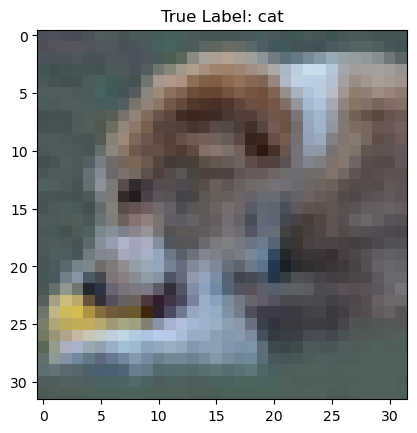

In [13]:
# Show a random image from the dataset

plot, index, label = show_random_image(train_data, mean=mean, std=std)

In [14]:
model = MLP(ARCH, 3*32*32, 10, best_configs['batch_norm']).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=best_configs['learning_rate'], momentum=best_configs['momentum'])

print(model)

MLP(
  (fc): Sequential(
    (0): Linear(in_features=3072, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=250, bias=True)
    (4): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=250, out_features=100, bias=True)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=10, bias=True)
  )
  (softmax): Softmax(dim=1)
)


Training the model...
---------------------
Epoch 1, Iteration 800/800, Loss: 2.1007387638092045
Epoch 1 done, Training Loss: 2.1230324149131774
Epoch 1, Validation Loss: 2.046741062402725
Epoch 1, Training Accuracy: 0.449025, Validation Accuracy: 0.429 

Epoch 2, Iteration 800/800, Loss: 2.0648484230041504
Epoch 2 done, Training Loss: 2.024829479008913
Epoch 2, Validation Loss: 2.0168127995729446
Epoch 2, Training Accuracy: 0.492475, Validation Accuracy: 0.4508 

Epoch 3, Iteration 800/800, Loss: 1.8918576240539556
Epoch 3 done, Training Loss: 1.9829583105444908
Epoch 3, Validation Loss: 1.9877881157398223
Epoch 3, Training Accuracy: 0.535375, Validation Accuracy: 0.4764 

Epoch 4, Iteration 800/800, Loss: 2.0922093391418457
Epoch 4 done, Training Loss: 1.9568115547299385
Epoch 4, Validation Loss: 1.9826100307703018
Epoch 4, Training Accuracy: 0.548675, Validation Accuracy: 0.4765 

Epoch 5, Iteration 800/800, Loss: 1.8914533853530884
Epoch 5 done, Training Loss: 1.9331798200309276
Ep

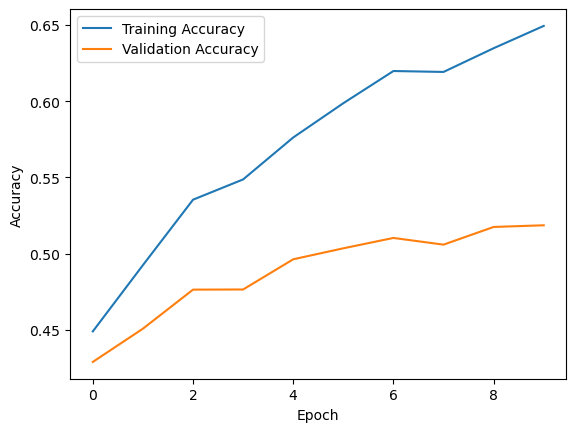

In [15]:
model, configs, train_acc, val_acc = train(best_configs, train_loader, val_loader, criterion, optimizer, model, device)

test_accuracy = get_accuracy(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy}')

plot_accuracies(train_acc, val_acc)

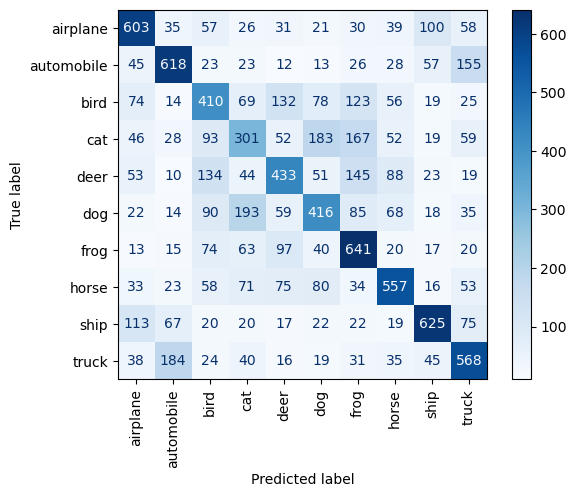

In [16]:
# Confusion Matrix

predicted_labels = get_predicted_labels(model, test_loader, device)
true_labels = test_data.targets

cm = confusion_matrix(true_labels, predicted_labels.cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS.values())
disp.plot(cmap='Blues', xticks_rotation='vertical')

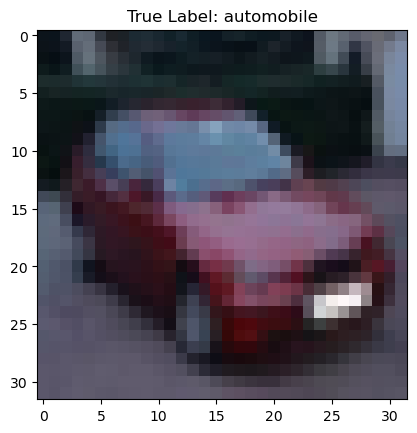

True Label: automobile
Predicted Label: automobile


In [19]:
# Show an random image and its predicted label

plot, index, label = show_random_image(test_data, mean=mean, std=std)

predicted_label = predicted_labels[index].item()
print(f'True Label: {LABELS[label]}')
print(f'Predicted Label: {LABELS[predicted_label]}')